# Walk forward optimization

Reference: https://github.com/polakowo/vectorbt/blob/master/examples/WalkForwardOptimization.ipynb

Reference 1: https://wire.insiderfinance.io/advanced-backtesting-on-nifty-using-walk-forward-analysis-in-python-90da743fcf78

Reference 2: https://pyquantnews.com/1000000-backtest-simulations-20-seconds-vectorbt/

Reference 3: https://algotrading101.com/learn/walk-forward-optimization/

Reference 4: https://www.forexfactory.com/thread/472656-why-walk-forward-analysis-is-still-unreliable-and

In [148]:
import numpy as np
import scipy.stats as stats
import vectorbt as vbt
import warnings

warnings.filterwarnings("ignore")

In [149]:
split_kwargs = dict(
    n=30, 
    window_len=365 * 2, 
    set_lens=(180,), # 
    left_to_right=False
)  # 30 windows, each 2 years long, reserve 180 days for test
pf_kwargs = dict(
    direction='LongOnly',  # long, short and both
    freq='d'
)

windows = np.arange(10, 50)

In [156]:
price = vbt.YFData.download('AAPL', missing_index="drop").get('Close')

In [158]:
def roll_in_and_out_samples(price, **kwargs):
    return price.vbt.rolling_split(**kwargs)

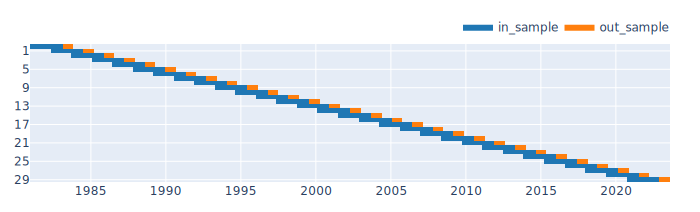

(550, 30) 30
(180, 30) 30


In [221]:
(in_price, in_indexes), (out_price, out_indexes) =\
            roll_in_and_out_samples(price, **split_kwargs)

roll_in_and_out_samples(price, plot=True, 
                        trace_names=["in_sample","out_sample"],
                        **split_kwargs).show_svg()

print(in_price.shape, len(in_indexes))
print(out_price.shape, len(out_indexes))

# Here n = 30 means we are dividing our total datapoints into 30 different windows, with each window lenght *2 from which
# 450 are insample data and 50 are out of the sample data

In [222]:
print(out_indexes[19].max())
print(out_indexes[19].min())


2009-11-13 05:00:00+00:00
2009-03-03 05:00:00+00:00


In [223]:
pf.returns()

Date
2009-03-02 05:00:00+00:00    0.0
2009-03-03 05:00:00+00:00    0.0
2009-03-04 05:00:00+00:00    0.0
2009-03-05 05:00:00+00:00    0.0
2009-03-06 05:00:00+00:00    0.0
                            ... 
2009-11-06 05:00:00+00:00    0.0
2009-11-09 05:00:00+00:00    0.0
2009-11-10 05:00:00+00:00    0.0
2009-11-11 05:00:00+00:00    0.0
2009-11-12 05:00:00+00:00    0.0
Length: 180, dtype: float64

In [224]:
def simulate_all_params(price, windows, **kwargs):
    fast_ma, slow_ma = vbt.MA.run_combs(
        price, windows, r=2, short_names=['fast', 'slow'])
    entries = fast_ma.ma_crossed_above(slow_ma)
    exits = fast_ma.ma_crossed_below(slow_ma)
    pf = vbt.Portfolio.from_signals(price, entries, exits, **kwargs)
    return pf.sharpe_ratio()


In [225]:
in_sharpe = simulate_all_params(in_price, windows,**pf_kwargs)
print(in_sharpe)

fast_window  slow_window  split_idx
10           11           0            0.453424
                          1            0.032089
                          2           -0.469838
                          3            0.709905
                          4            2.002159
                                         ...   
48           49           25           0.629877
                          26           2.220341
                          27           1.650278
                          28           0.983049
                          29          -0.503428
Name: sharpe_ratio, Length: 23400, dtype: float64


In [226]:
def get_best_index(performance, higher_better=True):
    if higher_better:
        return performance[performance.groupby(
            'split_idx').idxmax()].index
    return performance[performance.groupby(
        'split_idx').idxmin()].index
in_best_index = get_best_index(in_sharpe)

print(in_best_index)

MultiIndex([(27, 37,  0),
            (15, 30,  1),
            (19, 22,  2),
            (35, 36,  3),
            (10, 11,  4),
            (11, 13,  5),
            (17, 18,  6),
            (19, 20,  7),
            (13, 15,  8),
            (12, 20,  9),
            (14, 29, 10),
            (10, 45, 11),
            (26, 32, 12),
            (48, 49, 13),
            (13, 15, 14),
            (28, 36, 15),
            (12, 14, 16),
            (10, 37, 17),
            (31, 32, 18),
            (38, 49, 19),
            (38, 49, 20),
            (41, 44, 21),
            (17, 24, 22),
            (32, 33, 23),
            (26, 29, 24),
            (10, 17, 25),
            (48, 49, 26),
            (18, 27, 27),
            (18, 20, 28),
            (19, 20, 29)],
           names=['fast_window', 'slow_window', 'split_idx'])


In [247]:
def get_best_params(best_index, level_name):
    return best_index.get_level_values(level_name).to_numpy()

in_best_fast_windows = get_best_params(in_best_index,"fast_window")
in_best_slow_windows = get_best_params(in_best_index, "slow_window")
in_best_window_pairs = np.array(list(zip(in_best_fast_windows, in_best_slow_windows)))
print(in_best_window_pairs)

[[27 37]
 [15 30]
 [19 22]
 [35 36]
 [10 11]
 [11 13]
 [17 18]
 [19 20]
 [13 15]
 [12 20]
 [14 29]
 [10 45]
 [26 32]
 [48 49]
 [13 15]
 [28 36]
 [12 14]
 [10 37]
 [31 32]
 [38 49]
 [38 49]
 [41 44]
 [17 24]
 [32 33]
 [26 29]
 [10 17]
 [48 49]
 [18 27]
 [18 20]
 [19 20]]


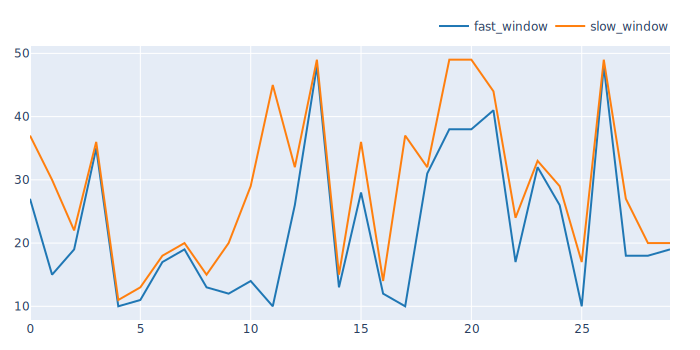

In [228]:
pd.DataFrame(in_best_window_pairs, columns=['fast_window', 'slow_window']).vbt.plot().show_svg()

In [229]:
# Simulate all params for out-sample ranges
out_sharpe = simulate_all_params(out_price, windows, **pf_kwargs)

print(out_sharpe)

fast_window  slow_window  split_idx
10           11           0           -1.635750
                          1            0.510985
                          2            1.036077
                          3            1.433579
                          4           -1.226708
                                         ...   
48           49           25           1.288928
                          26           1.209520
                          27           2.050741
                          28           1.272411
                          29           2.108858
Name: sharpe_ratio, Length: 23400, dtype: float64


In [230]:
def simulate_best_params(price, best_fast_windows, best_slow_windows, **kwargs):
    fast_ma = vbt.MA.run(price, window=best_fast_windows, per_column=True)
    slow_ma = vbt.MA.run(price, window=best_slow_windows, per_column=True)

    entries = fast_ma.ma_crossed_above(slow_ma)
    exits = fast_ma.ma_crossed_below(slow_ma)

    pf = vbt.Portfolio.from_signals(price, entries, exits, **kwargs)
    return pf.sharpe_ratio()

In [231]:
out_test_sharpe = simulate_best_params(
    out_price, 
    in_best_fast_windows, 
    in_best_slow_windows, 
    direction="both", 
    freq="d"
)
print(out_test_sharpe)

ma_window  ma_window  split_idx
27         37         0            1.709994
15         30         1            0.496050
19         22         2            1.903047
35         36         3           -0.513083
10         11         4           -1.981186
11         13         5           -0.534257
17         18         6           -1.903761
19         20         7            0.843401
13         15         8            0.457506
12         20         9            0.917088
14         29         10           1.898677
10         45         11           0.561127
26         32         12          -0.173749
48         49         13           0.293351
13         15         14          -0.410594
28         36         15          -1.155256
12         14         16          -1.939144
10         37         17           0.194498
31         32         18           0.054854
38         49         19                inf
                      20                inf
41         44         21          -0.898228


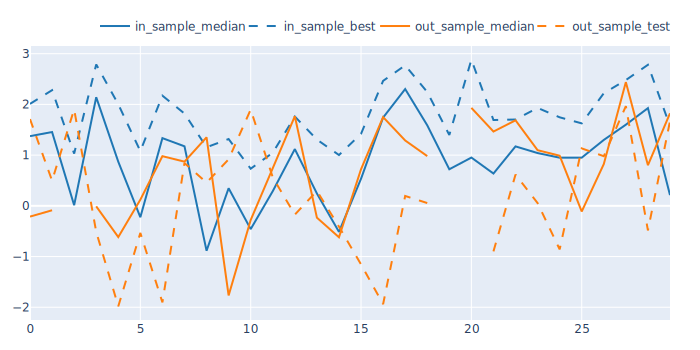

In [238]:
cv_results_df = pd.DataFrame({
    #'in_sample_hold': in_hold_sharpe.values,
    'in_sample_median': in_sharpe.groupby('split_idx').median().values,
    'in_sample_best': in_sharpe[in_best_index].values,
    #'out_sample_hold': out_hold_sharpe.values,
    'out_sample_median': out_sharpe.groupby('split_idx').median().values,
    'out_sample_test': out_test_sharpe.values
})

color_schema = vbt.settings['plotting']['color_schema']

cv_results_df.vbt.plot(
    trace_kwargs=[
        dict(line_color=color_schema['blue']),
        dict(line_color=color_schema['blue'], line_dash='dash'),
        #dict(line_color=color_schema['blue'], line_dash='dot'),
        dict(line_color=color_schema['orange']),
        dict(line_color=color_schema['orange'], line_dash='dash'),
        #dict(line_color=color_schema['orange'], line_dash='dot')
    ]
).show_svg()

In [255]:
# Perform independent t test 
## Alternative hypothesis: out-of-sample sharpe ratio > in-sample sharpe ratio if p-value < 0.05

in_sample_best = in_sharpe[in_best_index].values
out_sample_test = out_test_sharpe.values

## data preprocessing - remove inf values, so it won't disrupt the t-test calculations
df = pd.DataFrame()
df["in_sample_best"] = in_sample_best
df["out_sample_test"] = out_sample_test
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True, axis=0)

# independ t-test
t, p = stats.ttest_rel(
    a=df["out_sample_test"],
    b=df["in_sample_best"],
    alternative="greater"
)

print(f"t-test statistics: {t}")
# if p-value close to 1, 
# it means out-of-sample sharpe ratio is NOT greater than in-sample sharpe ratio (as shown in boxplot below)
# and this suggest there is overfitting for your strategy 
print(f"p-value: {p}")

t-test statistics: -5.9815292314787
p-value: 0.9999988893981844


<Axes: >

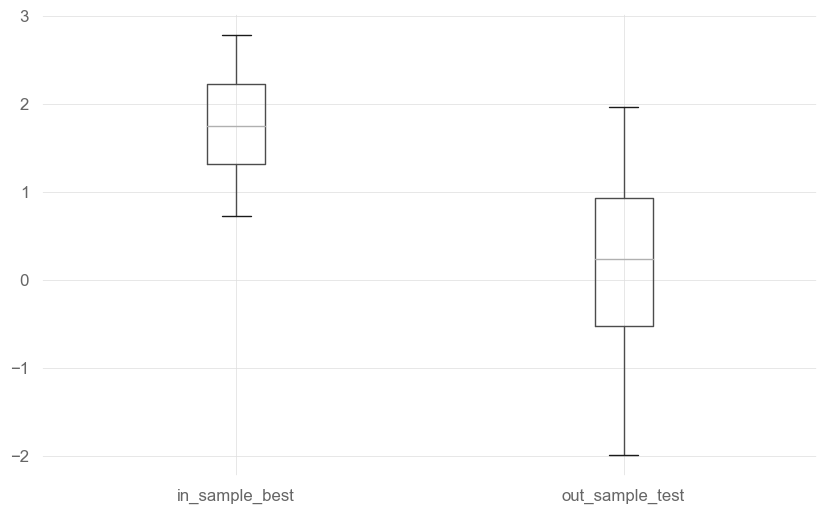

In [258]:
# a double check that in_sample sharpe ratio is much greater than out-of-sample sharpe ratio for your strategy
df.boxplot()